In [1]:
import cProfile
from mpl_toolkits import mplot3d
import scipy.spatial
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import copy

# Local imports
import oggm
from oggm.core.massbalance import LinearMassBalance, ScalarMassBalance
from oggm.core.inversion import find_sia_flux_from_thickness
from oggm import utils, cfg
from oggm.cfg import SEC_IN_DAY, SEC_IN_YEAR
from oggm.core.sia2d import Upstream2D
from oggm.exceptions import InvalidParamsError
cfg.initialize(logging_level='WARNING')

# Tests
from oggm.tests.funcs import (dummy_bumpy_bed, dummy_constant_bed,
                              dummy_constant_bed_cliff,
                              dummy_mixed_bed, dummy_constant_bed_obstacle,
                              dummy_noisy_bed, dummy_parabolic_bed,
                              dummy_trapezoidal_bed, dummy_width_bed,
                              dummy_width_bed_tributary, bu_tidewater_bed,
                              dummy_bed_tributary_tail_to_head)

# after oggm.test
import matplotlib.pyplot as plt

from oggm.core.flowline import (KarthausModel, FluxBasedModel,
                                MassRedistributionCurveModel,
                                MassConservationChecker)
from oggm.tests.ext.sia_fluxlim import MUSCLSuperBeeModel

#from oggm.core.sia2d import(Model2D, Upstream2D)

FluxBasedModel = partial(FluxBasedModel, inplace=True)
KarthausModel = partial(KarthausModel, inplace=True)
MUSCLSuperBeeModel = partial(MUSCLSuperBeeModel, inplace=True)

2023-02-13 13:19:33: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-02-13 13:19:33: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-02-13 13:19:33: oggm.cfg: Multiprocessing: using all available processors (N=16)


First we select how we want to run the code

match_OGGM determines what version of OGGM we want to run over, the basic version that just runs the SIA equations (Like our code) or the production version

bed_shape determines what shape we want the bed of the glacier to be

use_numerical_method determines which stepping equation we are using when solving the SIA not currently doing anything but I might want it to in the future?

use_SIA determines which SIA solving method we use, upstream is the version of the SIA we are comparing MUSCL to so normally we will be running both

use_H_method determines with H_plus/H_min method are being used in MUSCL

use_MB determines which mass balance method you want to use, scalar has the glacier growing by the same about every year, linear has the glacier growing linearly, and steadstate is having the glacier reach equilibrium

In [2]:
#decide which version of the OGGM code we are going to match
match_OGGM = "basic" #options are basic, production

#Decide bed shape
bed_shape = "rectangle" #options are rectangle, trapezoid, parabolic, cliff, multitrib

# numberical Methods
#use_numerical_method = "use_TVD" #options are use_E use_TVD and use_nTVD 
#not currently doing anything but I might want it to in the future?

#shallow ice solving method
use_SIA = 'both' #options are both, use_MUSCL, or use_upstream

#H_plus/min function
use_H_method = "use_superbee" #options are use_minmod and use_superbee

#mass balance method
use_MB = "linear" #options are linear, scalar, and steadystate

then we set the number of years we want to run over by adjusting num_yrs and change the slope of our bed and our DEM grid spacing by adjusting dx and dy

In [3]:
#Pick number of years to run over
yr_start = 0.0 #start year 0
num_yrs = 120 # Only change this number
yrs = np.arange(1, num_yrs+1)

# Bed shape, can change these
max_elev = 3000. # default 3000m
min_elev = 1000. # default 1000m
Nx = 200         # default 200
dx = 100         # DEM grid spacing in meters down glacier, default 100m

# only bed_shape=="rectangle" uses the_wid as an input (default 300 m)
the_wid = 200 # can change (m)

# Can change these and input to OGGM
if bed_shape == "cliff"    : 
    cliff_hgt = 250. # cliff drop default 250m 
    if match_OGGM=="basic" or match_OGGM=="production": the_wid = dx   # this is not changeable in OGGM dummy model
if bed_shape == "parabolic": shape = 5.e-3    # parabola shape, default 5.e-3 which is flattish, if use 5.e3 very curved
if bed_shape == "trapezoid": 
    lambdas = 2     # default 2, or atan(2/lambdas)=angle of side wall from horizontal, 2 is 45 deg, 1 is steeper
    bot_wid = 160    # bottom width of trapezoid (m)
    if match_OGGM=="basic" or match_OGGM=="production":
        the_wid = dx   # this is not changeable in OGGM dummy model
        bot_wid = 160. # this is not changeable in OGGM dummy model
    
#DEM grid spacing in meters across glacier, OGGM uses same dx as dy
dy = 20.
if match_OGGM=="basic" or match_OGGM=="production": dy = dx 
dxdy=dx*dy
x = np.arange(0.5, Nx + 0.5, 1)*dx
dist = x
x_m = Nx*dx # max length of the glacier
y_m = the_wid #width of the glacier

bed_h = np.linspace(max_elev,min_elev,Nx)

slope_h = np.linspace(max_elev,min_elev,Nx) #elevation[m] of constant slope bedrock at the flowline grid points
bed_h1=slope_h

Then we set the glacier ELA and the rate the mass balance changes

In [4]:
ELA = 2600. #2800. #ELA (m)
mdot_grad = 20. #mbgradient (mm/yr/m, default=3.)
mdot_con = 3. #mb (mm/yr)

we then define the constants for the glacier code

In [5]:
A = cfg.PARAMS['glen_a'] # Modern style Glen parameter A 2.4e-24
n = cfg.PARAMS['glen_n'] # 3.0
g = 9.81 #m/s^2
rho = cfg.PARAMS['ice_density'] # 900.0kg/m^3
Gamma = 2.0*A*(rho*g)**n/(n+2)
cfl = 0.124
cfl_number = cfg.PARAMS['cfl_number'] #CFL criterion (dt = cfl_number * dx / max_u

We then set the timesteps

In [6]:
# prevent adaptive time-stepping
max_dt = 31*SEC_IN_DAY #max timestep in seconds
fixed_dt_use = None # 10 * SEC_IN_DAY   #parabolic and constant works
if bed_shape == "cliff": fixed_dt_use = 2 * SEC_IN_DAY   #need for cliff

The model and beds are then defined for OGGM

In [7]:
# define model and beds
if match_OGGM == "production":
    models = [FluxBasedModel,MUSCLSuperBeeModel]
    mymodels=["Flux Based","MUSCL SB"]

if match_OGGM == "basic":
    models = [Upstream2D]
    mymodels=["Upstream 2D"]

# Karthaus does not work unless constant bed
if (bed_shape == "parabolic" or "trapezoid") and mymodels[0]=="Karthaus":
    models = models[1:]
    mymodels=mymodels[1:]

# define model and beds
if bed_shape == "rectangle": modelnames=["OGGM " + s+ " Constant Bed" for s in mymodels]
if bed_shape == "cliff": modelnames=["OGGM " + s+ " Constant Bed Cliff" for s in mymodels]
if bed_shape == "parabolic": modelname=["OGGM " + s+ " Parabolic Bed" for s in mymodels]
if bed_shape == "trapezoid": modelnames=["OGGM " + s+ " Trapezoidal Bed" for s in mymodels]

reset function

In [8]:
def reset(bed_shape):
    if bed_shape == "rectangle": fls = dummy_constant_bed(hmax=max_elev, hmin=min_elev, nx=Nx, map_dx=dx,widths=the_wid/100.)
    if bed_shape == "cliff": fls = dummy_constant_bed_cliff(hmax=max_elev, hmin=min_elev, nx=Nx, map_dx=dx,cliff_height=cliff_hgt)
    if bed_shape == "parabolic": fls = dummy_parabolic_bed(hmax=max_elev, hmin=min_elev, nx=Nx, map_dx=dx,default_shape=shape,from_other_shape=None, from_other_bed=None)
    if bed_shape == "trapezoid": fls = dummy_trapezoidal_bed(hmax=max_elev, hmin=min_elev, nx=Nx, map_dx=dx,def_lambdas=lambdas)
    return fls

Bed test function

In [9]:
def test_bed(glen_a, yrs, models, mb0):
    lens = []
    volume = []
    areas = []
    surface_h = []
    widths = []
    
    mb = mb0
    
    fls = reset(bed_shape)
    
    if match_OGGM == "basic":
        length = yrs * 0.
        vol = yrs * 0.
        area = yrs * 0
        
        for model in models:
            model = model(B, dx=dx, mb_model=mb, y0=yr_start,
                          ice_thick_filter= None)
            for i, y in enumerate(yrs):
                model.run_until(y)
                assert model.yr == y
                surf_1d = model.ice_thick[Mny]
                length[i] = np.sum(surf_1d > 0) * model.dx
                vol[i] = model.volume_km3# / 3
                area[i] = model.area_km2# / 3

            lens.append(length)
            volume.append(vol)
            areas.append(area)
            surface_h.append(model.surface_h[Mny])
        
    
            
    if match_OGGM == "production":
        length = yrs * 0.
        vol = yrs * 0.
        area = yrs * 0
        
        for model in models:
            model = model(fls, mb_model=mb, glen_a=glen_a,y0 = yr_start,
                       fixed_dt=None)
                
            for i, y in enumerate(yrs):
                model.run_until(y)
                assert model.yr == y
                length[i] = fls[-1].length_m
                vol[i] = fls[-1].volume_km3
                area[i] = fls[-1].area_km2

            lens.append(length)
            volume.append(vol)
            areas.append(area)
            surface_h.append(fls[-1].surface_h.copy())
            
    bed_h = fls[-1].bed_h
        
    return(lens, volume, surface_h, widths, bed_h)

Calculating the mass balance from the OGGM model

In [10]:
Ny = int(the_wid/dy)+1
y = np.arange(0.5, Ny+0.5, 1)*dy
B = np.zeros((Ny,Nx))

if bed_shape == "rectangle":
    for yd in range(Ny):
        for xd in range(Nx):
            B[yd][xd] = slope_h[xd]
            
if bed_shape == "trapezoid":
    for yd in range(Ny):
        base = 0
        if y[yd] <= (y_m-bot_wid)/2:
            base = (y_m-bot_wid)/2-y[yd]          
        if y[yd] >= (y_m-bot_wid)/2+bot_wid:
            base = y[yd]-(y_m-bot_wid)/2-bot_wid
        for xd in range(Nx):
            B[yd][xd] = 2*base/lambdas+slope_h[xd]
    
if bed_shape == "parabolic":
    for yd in range(Ny):
        base = abs(y[yd] - the_wid/2.)
        for xd in range(Nx):
             B[yd][xd] = shape*(base**2.) + slope_h[xd]  
    
#add a cliff
if bed_shape == "cliff":
    for yd in range(Ny):
        for xd in range(Nx):
            B[yd][xd] = slope_h[xd]
        B[yd][50:] = B[yd][50:] - cliff_hgt

if (Ny % 2) == 0:
    Mny = int((Ny)/2.)-1
else:
    Mny = int((Ny)/2.) 

In [11]:
def width_m(H):
    #compute the widths out of H and the bed shape
    if bed_shape == "rectangle" or "cliff":
        wid = the_wid + H*0.
    if bed_shape == "parabolic":
        wid = np.sqrt(4*H/shape)
    if bed_shape == "trapezoid":
        wid = bot_wid + lambdas+H
    return wid
def volume_km3(H):
    vol3 = np.sum(H*dxdy)*1e-9
    if match_OGGM == "production": #I was supposed to fix something here, differentiate the volume maybe? 
        #or just calculate the volumes using volume finding equations for the different shapes?
        vol3 = np.sum(H*dxdy)*1e-9
    #if bed_shape == "parabolic": #what's the volume of a parabolic is you differentiate
    #    vol3 = -999 #CALCULATE
    #if bed_shape == "trapezoid":
    #    vol3 = -999 #CALCULATE        
    return vol3
def length_m(H):
    Dif = np.nonzero(H)
    length=x[Dif[0][-1]]+dx/2
    return length

We start my importing the OGGM code as well as and of the Python packages needed to make my code run

In [12]:
if use_MB == "scalar": #  input is mb (mm/yr, default =0) if you make this too positive it will grow out of domain boundaries (- or +10. is okay)
    print("Scalar")
    mb = ScalarMassBalance(mdot_con)
    file = 'test_bed_scalar' #to save
    lens1, volume1, surface_h1, widths1, bed_h1 = test_bed(A,yrs,models,mb)
    np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1) 
if use_MB == "linear": #  input is ELA (m, required), gradient (mm/yr/m, default=3.), max mb cap (mm/yr, default=none)
    print("linear")
    mb = LinearMassBalance(ELA,mdot_grad)
    file = 'test_bed_linear' #to save
    fls = reset(bed_shape)
    lens1, volume1, surface_h1, widths1, bed_h1 = test_bed(A,yrs,models,mb)
    np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1)

linear


The flux equation, called the both the UPSTREAM and MUSCL solving methods

In [13]:
# flux
def flux(sjpl, sjml, sjplp, sjmlp, sjlp, sjl, dj, dl):
    flux = (((((sjpl-sjml)+sjplp-sjmlp)**2.) / (4*dj)**2.)+(sjlp-sjl)**2./dl**2 )**((n-1.)/2.)
    return flux

midmod/superbee equations Currently you have to change the way the MUSCl code is written to use Minmod

In [14]:
# standard minmod functioin
def minmod(a,b):
    sign = (np.sign(a)+np.sign(b))
    minmod = sign/2*(np.minimum(np.abs(a), np.abs(b)))
    return minmod

def superbee(r):
    superbee =np.maximum(0,np.minimum(2.*r,1), np.minimum(r,2.)) 
    return superbee

The Shallow Ice approximation, the equation is Equation 36 from Jarosch 2013, finds the div in both MUSCL and UPSTREAM

In [15]:
# Shallow Ice approximation
def SIA(Dup, Sup, S, Ddn, Sdn, d):
    SIA=((Dup * (Sup - S))/d - (Ddn * (S - Sdn))/d)/d #equation 36 Jarosh 2013
    return SIA

The Indexing equations

In [16]:
# index
def H_index(h1, h2):
    H_index = 0.5*(h1+h2)
    return H_index

# H up index
def H_plus(Hm, H, Hp):
    if use_H_method == "use_minmod":
        H_plus = H - 0.5*minmod((H-Hm),(Hp-H))*(Hp-H)
    if use_H_method == "use_superbee":
        H_plus=H*0
        H_plus[Hp!=H] = (H - 0.5*superbee((H-Hm)/(Hp-H))*(Hp-H))[Hp!=H]
    return H_plus

# H down index
def H_min(Hm, H, Hp):
    if use_H_method == "use_minmod":
        H_min = H + 0.5*minmod((H-Hm),(Hp-H))*(Hp-H)
    if use_H_method == "use_superbee":
        H_min=H*0
        H_min[Hp!=H] = (H + 0.5*superbee((H-Hm)/(Hp-H))*(Hp-H))[Hp!=H]
    return H_min   

The differential solving methods

In [17]:
# # Methods    
# # Euler
# def E(u, Lu, deltat):
#     E = u-deltat*Lu
#     return E

# # TVD second order Runge-Kutta method
# def TVDu1(u, Lu, deltat):
#     TVDu1 = u+deltat*Lu
#     return TVDu1

# def TVD(u, Lu, L1, deltat):
#     TVD = u+(0.5)*deltat*Lu+1/2*deltat*L1
#     return TVD

# # non TVD Runge-Kutta method method
# def nTVDu1(u, Lu, deltat):
#     nTVDu1 = u-20*deltat*Lu
#     return nTVDu1

# def nTVD(u, Lu, L1, deltat):
#     nTVD = u+(41.0/40.0)*deltat*Lu-1.0/40.0*deltat*L1
#     return nTVD

The accumulation/mass balance equations

In [18]:
#steady State
def accumulationss(x,mdot_0,n,x_m): 
    mdot = ((n*mdot_0)/(x_m**(2.*n-1.)))*x**(n-1.)*(abs(x_m-x)**(n-1.))*(x_m-2.*x) # Eq. 54 Jarosch 2013 
    mdot[x>x_m] = 0.
    return mdot

#Linear
def accumulationl(heights):
    mdot = (heights-ELA)*(mdot_grad)
    return mdot

Calculating the width and the volume of the glacier

OGGM Methods

In [19]:
# define methods
methods = []
if use_SIA == "use_upstream": methods = methods + ["upstream"]
if use_SIA == "use_MUSCL": methods = methods + ["MUSCL"]
if use_SIA == "both": 
    methods = methods + ["upstream"]
    methods = methods + ["MUSCL"]
print(methods)
    
if bed_shape == "rectangle": methodnames=["My Model " + s+ " Constant Bed" for s in methods]
if bed_shape == "cliff": methodnames=["My Model " + s+ " Constant Bed Cliff" for s in methods]
if bed_shape == "parabolic": methodnames=["My Model " + s+ " Parabolic Bed" for s in methods]
if bed_shape == "trapezoid": methodnames=["My Model " + s+ " Trapezoidal Bed" for s in methods]

['upstream', 'MUSCL']


Calculating the Mass balance

In [20]:
# accumulation for m/s at each site, linear updates every year based on glacier surface elevation
def distrib_mb(surface_h):
    m_dot_linear = np.zeros((Ny,Nx))
    m_dot_scalar = np.zeros((Ny,Nx))
    m_dot_steady = np.zeros((Ny,Nx))
        
    if use_MB == "linear": 
        mb = LinearMassBalance(ELA,mdot_grad)
        mb_linear = mb.get_annual_mb(surface_h) #m/s?
        for yd in range(Ny):
            for xd in range(Nx):
                m_dot_linear[yd][xd] =  mb_linear[xd] #m/yr 
    if use_MB == "scalar": 
        mb = ScalarMassBalance(mdot_con)
        mb_scalar = mb.get_annual_mb(surface_h) #m/s
        for yd in range(Ny):
            for xd in range(Nx):
                m_dot_scalar[yd][xd] = mb_scalar[xd] 
    if use_MB == "steadystate":
        mdot = accumulationss(x, mdot_con, n, x_m) #m/yr 
        for yd in range(Ny):
            for xd in range(Nx):
                m_dot_steady[yd][xd] = mdot[xd]/SEC_IN_YEAR #m/s
                
    return(m_dot_linear, m_dot_scalar, m_dot_steady)

Define the finite difference indicies

In [21]:
# finite difference index x direction down the length of the glacier
l = np.arange(0, Nx)
lp = np.hstack([np.arange(1,Nx),Nx-1])
lpp = np.hstack([np.arange(2, Nx), Nx-1, Nx-1])
lm = np.hstack([0, np.arange(0, Nx-1)])
lmm = np.hstack([0, 0, np.arange(0, Nx-2)])

# finite difference index y direction across the glacier
k = np.arange(0, Ny)
kp = np.hstack([np.arange(1,Ny),Ny-1])
kpp = np.hstack([np.arange(2, Ny), Ny-1, Ny-1])
km = np.hstack([0, np.arange(0, Ny-1)])
kmm = np.hstack([0, 0, np.arange(0, Ny-2)])



My actual model, the upstream version

In [22]:
#my model
#upstream method
def diffusion_upstream(S,B):
    H = S-B #H = ice thickness, S = Surface height, B = bed topography  

    #optimize
    Sklp = S[k][:,lp]
    Sklm = S[k][:,lm]
    Skplp = S[kp][:,lp]
    Skplm = S[kp][:,lm]
    Skpl = S[kp][:,l]
    Skl = S[k][:,l]
    Skmlp = S[km][:,lp]
    Skmlm = S[km][:,lm]
    Skml = S[km][:,l]

    #calculate l indicies
    Hl = H[k][:,l]
    Hlp = H[k][:,lp]
    Hlm = H[k][:,lm]

    H_l_up = H_index( Hlp , Hl )
    H_l_down = H_index( Hl , Hlm )

    # l upstream    
    H_l_upstream_up = np.zeros((Ny,Nx))
    H_l_upstream_up[Sklp>Skl]  = Hlp[Sklp>Skl]
    H_l_upstream_up[Skl>=Sklp] = Hl[Skl>=Sklp]
        
    H_l_upstream_down = np.zeros((Ny,Nx))
    H_l_upstream_down[Skl>Sklm]  = Hl[Skl>Sklm]
    H_l_upstream_down[Sklm>=Skl] = Hlm[Sklm>=Skl]      
    
    #calculate l flux
    f_l_plus = flux(Skpl, Skml, Skplp, Skmlp, Sklp, Skl,dx,dy)
    f_l_min = flux(Skpl, Skml, Skplm, Skmlm, Skl, Sklm,dx,dy)

    # calculate l Diffusivity
    D_l_up = Gamma * H_l_up**(n+1) * H_l_upstream_up * f_l_plus
    D_l_dn = Gamma * H_l_down**(n+1) * H_l_upstream_down * f_l_min

    #calculate k indicies 
    Hk = H[k][:,l]
    Hkp = H[kp][:,l]
    Hkm = H[km][:,l]

    H_k_up = H_index( Hkp , Hk )
    H_k_down = H_index( Hk , Hkm )

    # k upstream    
    H_k_upstream_up = np.zeros((Ny,Nx))
    H_k_upstream_up[Skpl>Skl]  = Hkp[Skpl>Skl]
    H_k_upstream_up[Skl>=Skpl] = Hk[Skl>=Skpl]

    H_k_upstream_down = np.zeros((Ny,Nx))
    H_k_upstream_down[Skl>Skml]  = Hk[Skl>Skml]
    H_k_upstream_down[Skml>=Skl] = Hkm[Skml>=Skl]

    #calculate k flux
    f_k_plus = flux(Sklp, Sklm, Skplp, Skplm, Skpl, Skl,dy,dx)
    f_k_min = flux(Sklp, Sklm, Skmlp, Skmlm, Skl, Skml,dy,dx)

    # calculate k Diffusivity
    D_k_up = Gamma * H_k_up**(n+1) * H_k_upstream_up * f_k_plus
    D_k_dn = Gamma * H_k_down**(n+1) * H_k_upstream_down * f_k_min

    # calculate delta t and t
    divisor = max(np.max(np.abs(D_k_up)), np.max(np.abs(D_k_dn)), np.max(np.abs(D_l_dn)), np.max(np.abs(D_l_dn)))
    if divisor==0: 
        dt_cfl = max_dt
    else:
        dt_cfl = cfl * min(dx**2., dy**2.) / divisor

    # the timestep
    div_k = SIA(D_k_up ,Skpl ,Skl, D_k_dn, Skml, dy) #equation 36 Jarosh 2013
    div_l = SIA(D_l_up ,Sklp ,Skl, D_l_dn, Sklm, dx) #equation 36 Jarosh 2013
    div_q = div_k+div_l

    return div_q, dt_cfl

my Actual model the muscl version, needs to be updated to run with the current everything

In [23]:
#MUSCL Scheme 
def diffusion_MUSCL(S, B):
    H = S-B
           
    Hkl = H[k][:,l]
    Hklp = H[k][:,lp]
    Hklpp = H[k][:,lpp]
    Hklm = H[k][:,lm]
    Hklmm = H[k][:,lmm]
    Hkpl = H[kp][:,l]
    Hkppl = H[kpp][:,l]
    Hkml = H[km][:,l]
    Hkmml = H[kmm][:,l]
    
    # at the k+1/2 index
    H_k_min_up = H_min(Hkml, Hkl, Hkpl)
            
    H_k_plus_up = H_plus(Hkl, Hkpl, Hkppl)     
                
    # at the k-1/2 index
    H_k_min_down = H_min(Hkmml, Hkml, Hkl)
            
    H_k_plus_down = H_plus(Hkml, Hkl, Hkpl)
            
    # at the l+1/2 index
    H_l_min_up = H_min(Hklm, Hkl, Hklp)
            
    H_l_plus_up = H_plus(Hkl, Hklp, Hklpp)
            
                
    # at the l-1/2 index
    H_l_min_down = H_min(Hklmm, Hklm, Hkl)
            
    H_l_plus_down = H_plus(Hklm, Hkl, Hklp)
            
    Sklp = S[k][:,lp]
    Sklm = S[k][:,lm]
    Skplp = S[kp][:,lp]
    Skplm = S[kp][:,lm]
    Skpl = S[kp][:,l]
    Skl = S[k][:,l]
    Skmlp = S[km][:,lp]
    Skmlm = S[km][:,lm]
    Skml = S[km][:,l]
                
    f_k_plus = flux(Sklp, Sklm, Skplp, Skplm, Skpl, Skl, dy, dx)
    f_k_min = flux(Sklp, Sklm, Skmlp, Skmlm, Skl, Skml, dy, dx)
            
    #calculate l flux
    f_l_plus = flux(Skpl, Skml, Skplp, Skmlp, Sklp, Skl, dx, dy)
    f_l_min = flux(Skpl, Skml, Skplm, Skmlm, Skl, Sklm, dx, dy)
                
    # calculate k Diffusivity
    D_k_up_m = Gamma * H_k_min_up**(n+2.) * f_k_plus #Equation 30 jarosch 2013
    D_k_up_p = Gamma * H_k_plus_up**(n+2.) * f_k_plus #Equation 30 Jarosch 2013
    D_k_up_min = np.minimum(D_k_up_m, D_k_up_p) #equation 31 Jarosch 2013
    D_k_up_max = np.maximum(D_k_up_m, D_k_up_p) #equation 32 Jarosch 2013
                
    D_k_dn_m = Gamma * H_k_min_down**(n+2) * f_k_min #Equation 30 Jarosch 2013
    D_k_dn_p = Gamma * H_k_plus_down**(n+2) * f_k_min #Equation 30 Jarosh 2013
    D_k_dn_min = np.minimum(D_k_dn_m, D_k_dn_p) #equation 31 Jarosch 2013
    D_k_dn_max = np.maximum(D_k_dn_m, D_k_dn_p) #equatioon 32 Jarosch 2013
                
    #equation 33 jarosh 2013
    D_k_up = np.zeros((Ny, Nx))
            
    D_k_up[np.logical_and(Skpl<=Skl,H_k_min_up<=H_k_plus_up)] = D_k_up_min[np.logical_and(Skpl<=Skl,H_k_min_up<=H_k_plus_up)]
    D_k_up[np.logical_and(Skpl<=Skl,H_k_min_up>H_k_plus_up)] = D_k_up_max[np.logical_and(Skpl<=Skl,H_k_min_up>H_k_plus_up)]
    D_k_up[np.logical_and(Skpl>Skl,H_k_min_up<=H_k_plus_up)] = D_k_up_max[np.logical_and(Skpl>Skl,H_k_min_up<=H_k_plus_up)]
    D_k_up[np.logical_and(Skpl>Skl,H_k_min_up>H_k_plus_up)] = D_k_up_min[np.logical_and(Skpl>Skl,H_k_min_up>H_k_plus_up)]
        
    D_k_dn = np.zeros((Ny,Nx))
            
    D_k_dn[np.logical_and(Skl<=Skml,H_k_min_down<=H_k_plus_down)] = D_k_dn_min[np.logical_and(Skl<=Skml,H_k_min_down<=H_k_plus_down)]
    D_k_dn[np.logical_and(Skl<=Skml,H_k_min_down>H_k_plus_down)] = D_k_dn_max[np.logical_and(Skl<=Skml,H_k_min_down>H_k_plus_down)]
    D_k_dn[np.logical_and(Skl>Skml,H_k_min_down<=H_k_plus_down)] = D_k_dn_max[np.logical_and(Skl>Skml,H_k_min_down<=H_k_plus_down)]
    D_k_dn[np.logical_and(Skl>Skml,H_k_min_down>H_k_plus_down)] = D_k_dn_min[np.logical_and(Skl>Skml,H_k_min_down>H_k_plus_down)]
            
    # calculate l Diffusivity
    D_l_up_m = Gamma * H_l_min_up**(n+2.) * f_l_plus #Equation 30 Jarosch 2013
    D_l_up_p = Gamma * H_l_plus_up**(n+2.) * f_l_plus #Equation 30 Jarosch 2013
    D_l_up_min = np.minimum(D_l_up_m, D_l_up_p) #equation 31 Jarosch 2013
    D_l_up_max = np.maximum(D_l_up_m, D_l_up_p) #equation 32 Jarosch 2013
                
    D_l_dn_m = Gamma * H_l_min_down**(n+2) * f_l_min #Equation 30 Jarosch 2013
    D_l_dn_p = Gamma * H_l_plus_down**(n+2) * f_l_min #Equation 30 Jarosh 2013
    D_l_dn_min = np.minimum(D_l_dn_m, D_l_dn_p) #equation 31 Jarosch 2013
    D_l_dn_max = np.maximum(D_l_dn_m, D_l_dn_p) #equatioon 32 Jarosch 2013
                
    #equation 33 jarosh 2013
    D_l_up = np.zeros((Ny, Nx))
            
    D_l_up[np.logical_and(Sklp<=Skl,H_l_min_up<=H_l_plus_up)] = D_l_up_min[np.logical_and(Sklp<=Skl,H_l_min_up<=H_l_plus_up)]
    D_l_up[np.logical_and(Sklp<=Skl,H_l_min_up>H_l_plus_up)] = D_l_up_max[np.logical_and(Sklp<=Skl,H_l_min_up>H_l_plus_up)]
    D_l_up[np.logical_and(Sklp>Skl,H_l_min_up<=H_l_plus_up)] = D_l_up_max[np.logical_and(Sklp>Skl,H_l_min_up<=H_l_plus_up)]
    D_l_up[np.logical_and(Sklp>Skl,H_l_min_up>H_l_plus_up)] = D_l_up_min[np.logical_and(Sklp>Skl,H_l_min_up>H_l_plus_up)]
        
    D_l_dn = np.zeros((Ny,Nx))
            
    D_l_dn[np.logical_and(Skl<=Sklm,H_l_min_down<=H_l_plus_down)] = D_l_dn_min[np.logical_and(Skl<=Sklm,H_l_min_down<=H_l_plus_down)]
    D_l_dn[np.logical_and(Skl<=Sklm,H_l_min_down>H_l_plus_down)] = D_l_dn_max[np.logical_and(Skl<=Sklm,H_l_min_down>H_l_plus_down)]
    D_l_dn[np.logical_and(Skl>Sklm,H_l_min_down<=H_l_plus_down)] = D_l_dn_max[np.logical_and(Skl>Sklm,H_l_min_down<=H_l_plus_down)]
    D_l_dn[np.logical_and(Skl>Sklm,H_l_min_down>H_l_plus_down)] = D_l_dn_min[np.logical_and(Skl>Sklm,H_l_min_down>H_l_plus_down)]
                
    # calculate delta t and stab_t
    divisor = max(np.max(np.abs(D_k_up)), np.max(np.abs(D_k_dn)), np.max(np.abs(D_l_dn)), np.max(np.abs(D_l_dn)))
    if divisor==0: 
        dt_cfl = max_dt
    else:
        dt_cfl = cfl * min(dx**2., dy**2.) / divisor
            
            
    # the time step
    div_k = SIA(D_k_up,Skpl, Skl, D_k_dn, Skml, dy) #equation 36 Jarosh 2013
    div_l = SIA(D_l_up,Sklp, Skl, D_l_dn, Sklm, dx) #equation 36 Jarosh 2013
    div_q = div_k+div_l

    return(div_q, dt_cfl)

The code to make the MUSCL and UPSTREAM code take a step

In [24]:
def step(S,B,m_dot,dt,t, method):
    """Advance one step."""

    if (method=="MUSCL"): div_q, dt_cfl = diffusion_MUSCL(S,B)
    if (method=="upstream"): div_q, dt_cfl = diffusion_upstream(S,B)
        
    deltat = min(dt_cfl,dt)
    if deltat > max_dt: deltat = max_dt  
    #if deltat < fixed_dt_use: deltat = fixed_dt_use

    Skl = S[k][:,l]
    S= Skl + (m_dot+div_q)*deltat #equation 35 Jarosh 2013, m_dot should be in seconds since times deltat
    S = np.maximum(S,bed_h) #does not seem like we should need this

    # Next step
    next_t = t + deltat

    return next_t, S

In [25]:
#upstream method
def year(y_end,S,B,m_dot,t, method):
    """Run until a selected year."""
    t_total = (y_end - yr_start) * SEC_IN_YEAR
    while t<t_total:
        dt = t_total-t
        t, S = step(S,B,m_dot,dt,t,method)
            
    flowlineSurf = S[Mny]
    width = width_m(S[Mny]-B[Mny])
    Dif = np.nonzero(S[Mny]-B[Mny])        
    length=x[Dif[0][-1]]+dx/2
    volume=volume_km3(S-B)

    return(S, t, length, volume, flowlineSurf, width)

In [26]:
def run_mymodel(yrs,S0,B,mb0,t0,elev_mb, methods):
    lens = []
    surface_h = []
    volume = []
    widths = []
    
    for method in methods: 
        S = S0
        mb = mb0  
        t = t0
        print(method)
 
        length = yrs * 0.
        vol = yrs * 0.
        surf_h = bed_h
        for i, y in enumerate(yrs):
            if elev_mb==1: mb, dont_use1, dont_use2 = distrib_mb(surf_h) #linear mb changes every year off surface height
            S, t, length[i], vol[i], surf_h, wid =  year(y,S,B,mb,t, method)
        lens.append(length)
        volume.append(vol)
        widths.append(wid)
        surface_h.append(surf_h)
        
    return(lens, volume, surface_h, widths)

In [27]:
#initialize mb, units of m/s
m_dot_linear, m_dot_scalar, m_dot_steady = distrib_mb(bed_h)

#run
if use_MB == "scalar": 
    file = 'mymodel_bed_scalar' #to save
    lens1, volume1, surface_h1, widths1 = run_mymodel(yrs,B,B,m_dot_scalar,0.,0, methods)
    np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1)
if use_MB == "linear": 
    file = 'mymodel_bed_linear' #to save
    lens1, volume1, surface_h1, widths1 = run_mymodel(yrs,B,B,m_dot_linear,0.,1, methods)
    np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1)

upstream
MUSCL


/var/folders/r_/xbzx7gps4nl_p1t__pq8v0jx1bngzm/T/ipykernel_29875/2359733688.py:21: RuntimeWarning: invalid value encountered in true_divide
  H_min[Hp!=H] = (H + 0.5*superbee((H-Hm)/(Hp-H))*(Hp-H))[Hp!=H]
/var/folders/r_/xbzx7gps4nl_p1t__pq8v0jx1bngzm/T/ipykernel_29875/2359733688.py:12: RuntimeWarning: invalid value encountered in true_divide
  H_plus[Hp!=H] = (H - 0.5*superbee((H-Hm)/(Hp-H))*(Hp-H))[Hp!=H]
/var/folders/r_/xbzx7gps4nl_p1t__pq8v0jx1bngzm/T/ipykernel_29875/2359733688.py:21: RuntimeWarning: divide by zero encountered in true_divide
  H_min[Hp!=H] = (H + 0.5*superbee((H-Hm)/(Hp-H))*(Hp-H))[Hp!=H]
/var/folders/r_/xbzx7gps4nl_p1t__pq8v0jx1bngzm/T/ipykernel_29875/2359733688.py:12: RuntimeWarning: divide by zero encountered in true_divide
  H_plus[Hp!=H] = (H - 0.5*superbee((H-Hm)/(Hp-H))*(Hp-H))[Hp!=H]


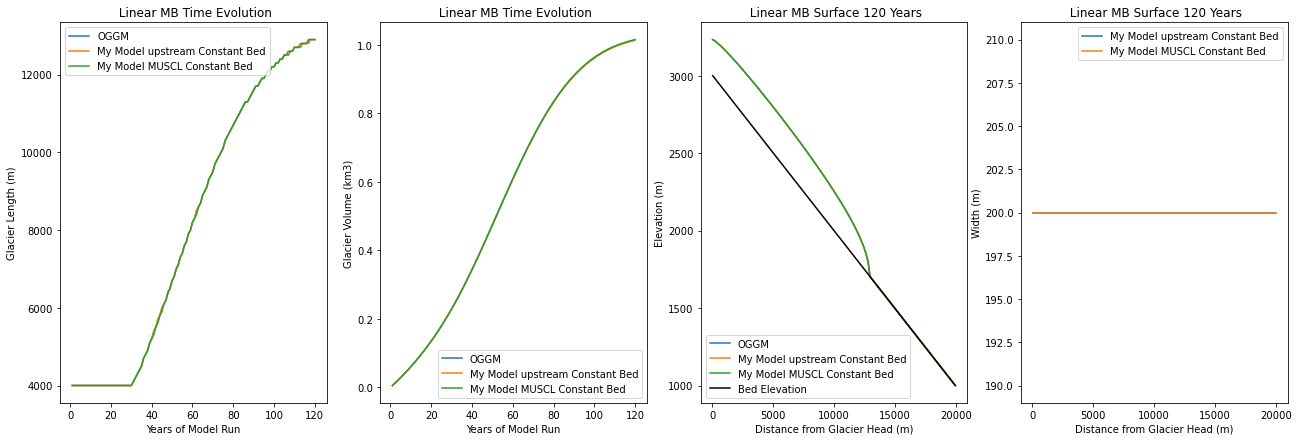

In [28]:
#load and plot models, should fix so doesn't try to plot if didn't run
plot_mymodel = 1 #plot model if 1, can turn off if skewing plots because so off
if use_MB == "linear":
    npzfile=np.load("test_bed_linear.npz")
    mm_npzfile=np.load("mymodel_bed_linear.npz")
    mbname = " Linear MB"
        
if use_MB == "scalar":
    npzfile=np.load("test_bed_scalar.npz")
    mm_npzfile=np.load("mymodel_bed_scalar.npz")
    mbname = " Scalar MB"
        
lens, volumes, surface_h, widths, bed_h = npzfile['lens'],npzfile['volume'],npzfile['surface_h'],npzfile['widths'],npzfile['bed_h']
length, volume, SurfaceElevation, width, bed_hh = mm_npzfile['lens'],mm_npzfile['volume'],mm_npzfile['surface_h'],mm_npzfile['widths'],mm_npzfile['bed_h']
fig = plt.figure(figsize=(22,7))
    
ax1 = fig.add_subplot(1,4,1)
for i, array in enumerate(lens):
    ax1.plot(yrs, array, label = 'OGGM')
if plot_mymodel==1: 
    for i, array in enumerate(length):
        ax1.plot(yrs, array, label = methodnames[i])    
ax1.set_xlabel('Years of Model Run')
ax1.set_ylabel('Glacier Length (m)')
ax1.legend()
ax1.set_title(mbname + " Time Evolution")

ax2 = fig.add_subplot(1,4,2)
for i, array in enumerate(volumes):
    ax2.plot(yrs, array, label = 'OGGM')
if plot_mymodel==1: 
    for i, array in enumerate(volume):
        ax2.plot(yrs, array, label = methodnames[i])
ax2.set_xlabel('Years of Model Run')
ax2.set_ylabel('Glacier Volume (km3)')
ax2.legend()
ax2.set_title(mbname + " Time Evolution")
    
ax3 = fig.add_subplot(1,4,3)
for i, array in enumerate(surface_h):
    ax3.plot(dist, array, label = 'OGGM')
if plot_mymodel==1: 
    for i, array in enumerate(SurfaceElevation):
        ax3.plot(dist, array, label = methodnames[i])
ax3.plot(dist,bed_h, 'k',label = "Bed Elevation",)
ax3.set_xlabel('Distance from Glacier Head (m)')
ax3.set_ylabel('Elevation (m)')
ax3.legend()
ax3.set_title(mbname + " Surface "+str(yrs[-1])+" Years")

ax4 = fig.add_subplot(1,4,4)
for i, array in enumerate(widths):
    ax4.plot(dist, array, label = 'OGGM')
if plot_mymodel==1: 
    for i, array in enumerate(width):
        ax4.plot(dist, array, label = methodnames[i])
ax4.set_xlabel('Distance from Glacier Head (m)')
ax4.set_ylabel('Width (m)')
ax4.legend()
ax4.set_title(mbname + " Surface "+str(yrs[-1])+" Years")

#plt.savefig("cliff.png")
plt.savefig(mbname[0:7]+ bed_shape +".png", bbox_inches='tight')
    
    